In [1]:
import clip
import torch
import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from segment_anything import sam_model_registry, SamPredictor

# Init CLIP and data

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/16", device=device)
model.eval()
preprocess =  Compose([Resize((224, 224), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

In [3]:
pil_img = Image.open("demo.jpg")
cv2_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
image = preprocess(pil_img).unsqueeze(0).to(device)
all_texts = ['airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground', 'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform', 'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa', 'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood']
target_texts = ['bench', 'person', 'ground', 'building']

## Explain raw predictions of CLIP, which are opposite and noisy.<br>
ith torch.no_grad():<br>
   # extract image features<br>
   image_features = model.encode_image(image)<br>
   image_features = image_features / image_features.norm(dim=1, keepdim=True)<br>
<br>
   # prompt ensemble for text features with normalization<br>
   text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)<br>
<br>
   # similarity map from image tokens with min-max norm and resize, B,H,W,N<br>
   features = image_features @ text_features.t()<br>
   similarity_map = clip.get_similarity_map(features[:, 1:, :], cv2_img.shape[:2])<br>
<br>
   # draw similarity map<br>
   for b in range(similarity_map.shape[0]):<br>
       for n in range(similarity_map.shape[-1]):<br>
           if all_texts[n] not in target_texts:<br>
               continue<br>
           vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')<br>
           vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)<br>
           vis = cv2_img * 0.4 + vis * 0.6<br>
           vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)<br>
           print('CLIP:', all_texts[n])<br>
           plt.imshow(vis)<br>
           plt.show()<br>
<br>
<br>
## Explain CLIP via our CLIP Surgery

In [4]:
model, preprocess = clip.load("CS-ViT-B/16", device=device)
model.eval()
#print(model)
#
#with torch.no_grad():
#    # clip architecture surgery acts on the image encoder
#    image_features = model.encode_image(image)
#    image_features = image_features / image_features.norm(dim=1, keepdim=True)
#
#    # prompt ensemble for text features with normalization
#    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)
#
#    # apply feature surgery
#    similarity = clip.clip_feature_surgery(image_features, text_features)
#    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])
#
#    # draw similarity map
#    for b in range(similarity_map.shape[0]):
#        for n in range(similarity_map.shape[-1]):
#            if all_texts[n] not in target_texts:
#                continue
#            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
#            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
#            vis = cv2_img * 0.4 + vis * 0.6
#            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
#            print('CLIP Surgery:', all_texts[n])
#            plt.imshow(vis)
#            plt.show()

CLIPSurgery(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   

# CLIP Surgery using higher resolution

In [5]:
preprocess =  Compose([Resize((512, 512), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])
image = preprocess(pil_img).unsqueeze(0).to(device)

CLIP Surgery 512: bench


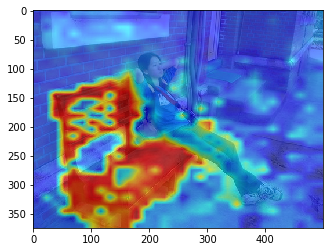

CLIP Surgery 512: building


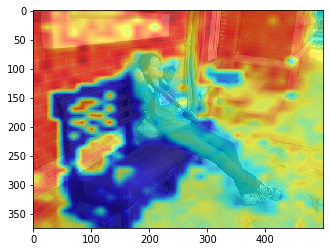

CLIP Surgery 512: ground


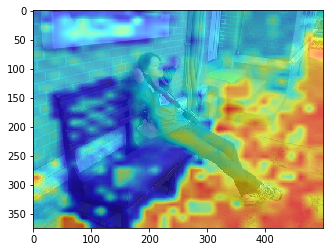

CLIP Surgery 512: person


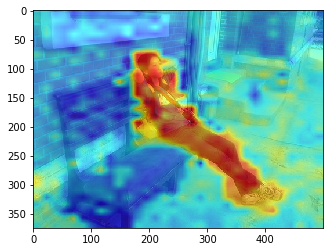

In [6]:
with torch.no_grad():
    # clip architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    # prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # apply feature surgery
    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery 512:', all_texts[n])
            plt.imshow(vis)
            plt.show()

# CLIP Surgery for a single text, without fixed label sets

In [7]:
texts = ['shoes']

CLIP Surgery for a single text: shoes


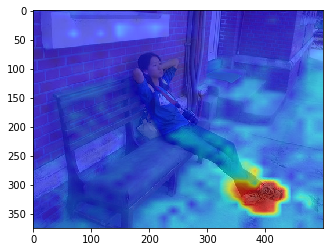

In [8]:
with torch.no_grad():
    # clip architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    # prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, texts, device)

    # extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # apply feature surgery for single text
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery for a single text:', texts[n])
            plt.imshow(vis)
            plt.show()

# Text to points from CLIP Surgery to guide SAM

Init SAM

In [9]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(np.array(pil_img))

inference CLIP Surgery and SAM

SAM guided by points from CLIP Surgery: bench


/home/ylini/CLIP_Surgery/clip/clip.py:335: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y = min((idx // w + 0.5) * scale_h, shape[0] - 1)
/home/ylini/CLIP_Surgery/clip/clip.py:341: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y = min((idx // w + 0.5) * scale_h, shape[0] - 1)


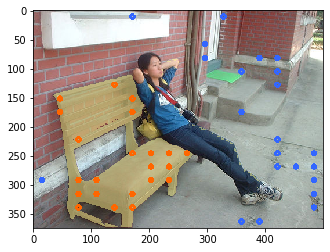

SAM guided by points from CLIP Surgery: building


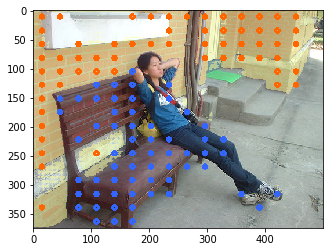

SAM guided by points from CLIP Surgery: ground


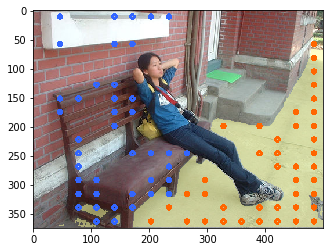

SAM guided by points from CLIP Surgery: person


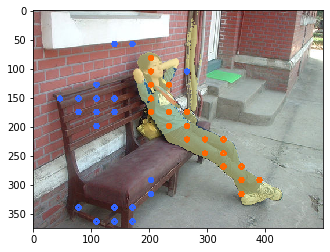

Sometimes, the points are accurate, while the masks from SAM still need improvements.
I mean, some failure cases are not caused by wrong points.


In [10]:
with torch.no_grad():
    # clip architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    # prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # apply feature surgery, no batch
    similarity = clip.clip_feature_surgery(image_features, text_features)[0]

    # inference SAM with points from CLIP Surgery
    for n in range(similarity.shape[-1]):
        if all_texts[n] not in target_texts:
            continue
        points, labels = clip.similarity_map_to_points(similarity[1:, n], cv2_img.shape[:2], t=0.8)
        masks, scores, logits = predictor.predict(point_labels=labels, point_coords=np.array(points), multimask_output=True)
        mask = masks[np.argmax(scores)]
        mask = mask.astype('uint8')

        # visualize the results
        vis = cv2_img.copy()
        vis[mask > 0] = vis[mask > 0] // 2 + np.array([153, 255, 255], dtype=np.uint8) // 2
        for i, [x, y] in enumerate(points):
            cv2.circle(vis, (x, y), 3, (0, 102, 255) if labels[i] == 1 else (255, 102, 51), 3)
        vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
        print('SAM guided by points from CLIP Surgery:', all_texts[n])
        plt.imshow(vis)
        plt.show()
    print('Sometimes, the points are accurate, while the masks from SAM still need improvements.')
    print('I mean, some failure cases are not caused by wrong points.')